In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
import math
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
import matplotlib.gridspec as gridspec
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker
from sklearn import preprocessing

In [2]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('max_growth', Float),
                  Column('max_loss', Float),
                  Column('max_price', Float),
                  Column('min_price', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

sma = Table('Sma', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('sma5', Float),
                Column('sma20', Float),
                Column('sma5_theta', Float),
                Column('sma20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

def get_smas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([sma]) \
            .where(and_(sma.c.coin == coin,
                        sma.c.date <= date,
                       sma.c.screen == screen))\
            .order_by(desc(sma.c.date))
    else:
        s = select([sma]) \
            .where(and_(sma.c.date <= date,
                        sma.c.screen == screen
                       ))\
            .order_by(desc(sma.c.date))
    rows = con.execute(s)
    sma_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not sma_df.empty:
        sma_df.columns = rows.keys()
    return sma_df

In [6]:
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna().drop(['price', 'volume', 'screen'], axis=1)

In [7]:
def calculate_obv(df_model):
    obv = []
    for i in range(len(df_model)):
        if i == 0:
            obv.append(0)
            p_price = df_model.iloc[i].price
            continue
        price = df_model.iloc[i].price
        volume = df_model.iloc[i].volume
        if price > p_price:
            obv.append(obv[i-1] + volume)
        elif price < p_price:
            obv.append(obv[i-1] - volume)
        else:
            obv.append(obv[i-1])
        p_price = price
    return obv

FETCH DATA FROM DATABASE AND JOIN TABLES 
MKTTREND - PRICE - MACDS - RSI - SMA

In [8]:
def manipulate_mkt_data():
    #Market Trend
    mkt_trend_df = get_mkt_trend()
    #Prices
    tickers_df_two = get_tickers()
    #MACD
    macds_df = get_macds()
    
    #Merge prices and macds
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin', 'screen'],
                          right_on=['date', 'coin', 'screen'])
    #Calculate relationship between Price and EMA
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    #Merge Prices and MKT TREND
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    #RSI
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    #SMA
    sma_df = get_smas()
    df = pd.merge(df, sma_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    full_data_set = df.drop(['sma20_theta', 'screen'], axis=1)
    dates_ = full_data_set[['date']]
    shifted_parms = full_data_set[['coin', 'dif_current', 'theta_current']].shift(2)
    shifted_parms['date'] = dates_
    full_data_set = pd.merge(full_data_set, shifted_parms, how='inner', left_on=['date', 'coin'],
                             right_on=['date', 'coin'])
    full_data_set['dif_current'] = full_data_set['dif_current_x']
    full_data_set['theta_current'] = full_data_set['theta_current_x']
    full_data_set['dif_base_p'] = full_data_set['dif_current_y']
    full_data_set['theta_base_p'] = full_data_set['theta_current_y']
    full_data_set = full_data_set.drop(['dif_current_x', 'dif_current_y',
                                        'theta_current_x', 'theta_current_y'], axis=1)
    full_data_set['dif_sma'] = full_data_set['sma5'] - full_data_set['sma20']
    df_model = pd.merge(full_data_set, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
    df_model = df_model.sort_values(['date'])
    df_model['theta_ema'] = df_model.theta_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
    df_model['dif_ema'] = df_model.dif_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
    df_model['strength_ema'] = df_model.strength.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
    df_model = df_model.dropna()
    df_model.loc[df_model['max_growth'] >= 0.1, 'growth_sign'] = 1
    df_model.loc[df_model['max_growth'] < 0.1, 'growth_sign'] = 0
    df_model.loc[df_model['max_loss'] <= -0.05, 'loss_sign'] = 1
    df_model.loc[df_model['max_loss'] > -0.05, 'loss_sign'] = 0
    dates_ = df_model[['date']]
    shifted_parms = df_model[['coin', 'max_growth', 'max_loss']].shift(1)
    shifted_parms['date'] = dates_
    df_model = pd.merge(df_model, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df_model['max_growth'] = df_model['max_growth_x']
    df_model['max_loss'] = df_model['max_loss_x']
    df_model['max_growth_p'] = df_model['max_growth_y']
    df_model['max_loss_p'] = df_model['max_loss_y']
    df_model = df_model.drop(['max_growth_x', 'max_growth_y', 'max_loss_x', 'max_loss_y'], axis=1)
    df_model['log_ret'] = np.log(df_model.price) - np.log(df_model.price.shift(1))
    df_model['log_ret_p'] = np.log(df_model.price) - np.log(df_model.price.shift(2))
    df_model = df_model[~(np.abs(df_model.d_dif-df.d_dif.mean())>(3*df_model.d_dif.std()))]
    df_model = df_model[~(np.abs(df_model.strength_ema-df_model.strength_ema.mean())>(3*df_model.strength_ema.std()))]
    df_model = df_model[~(np.abs(df_model.d_theta-df.d_theta.mean())>(3*df_model.d_theta.std()))]
    df_model = df_model.dropna()
    df_model = df_model.sort_values(['date'])
    df_model = df_model.drop(['coin', 'date', 'vote'], axis=1)
    p_price = 0
    df_model['obv'] = calculate_obv(df_model)
    df_model['max_rel'] = np.log(df_model['max_price']/ df_model['price'])
    df_model['min_rel'] = np.log(df_model['min_price']/ df_model['price'])
    df_model['rsi'] = df_model['rsi']/100
    df = df_model.drop(['macd_line', 'signal_line', 'dif_ema', 'loss_sign',
                           'theta_ema', 'max_loss', 'max_growth',
                         'd_theta', 'max_loss_p', 'd_dif', 'max_price', 'min_price',
                         'price', 'sma5', 'sma20', 'ema12', 'ema_26', 'sma5_theta',
                         'volume', 'strength', 'macd_line', 'signal_line', 'dif_base_p',
                   'theta_base_p'] ,axis=1)
    return df
    
df = manipulate_mkt_data().reset_index().drop(['index'], axis=1)
df.head()

USDT_BTC


,dif_base,theta_base,histogram,ema_dif,rsi,dif_current,theta_current,dif_sma,strength_ema,growth_sign,max_growth_p,log_ret,log_ret_p,obv,max_rel,min_rel
0,-122.140918,-1.029493,0.217394,0.034628,0.472855,-110.649790,-1.039892,-174.556434,1.920465e+08,0.0,0.045572,0.004776,0.072504,0.000000e+00,0.009511,-0.294214
1,-110.649790,-0.998318,14.157369,0.047077,0.442413,-99.850602,-1.023991,-119.273844,2.325315e+08,0.0,0.040797,0.016739,0.021514,9.281549e+06,0.024058,-0.189483
2,-99.850602,-0.990019,7.599137,-0.042936,0.397968,-105.950934,-1.024274,-110.550500,-6.115003e+08,1.0,0.014982,-0.102754,-0.086016,-3.425983e+06,0.126812,-0.026677
3,-105.950934,-0.985821,21.504717,0.004230,0.386852,-92.319915,-1.029346,-69.852406,-1.323244e+08,1.0,0.107694,0.048916,-0.053839,7.304115e+06,0.077897,-0.075592
4,-92.319915,-0.990164,27.710691,0.017198,0.363564,-82.180910,-1.040541,-50.557406,-4.844016e+07,0.0,0.104790,0.014600,0.063516,1.260134e+07,0.063297,-0.090192


In [ ]:
strength_ema, obv

In [9]:
train = df.iloc[0:math.floor(len(df)*0.75)].copy()
test = df.iloc[math.floor(len(df)*0.75):len(df)].copy()

scale_columns = ['theta_current', 'dif_current', 'theta_base','dif_base',
                 'dif_sma', 'strength_ema', 'obv']
    

scaler = preprocessing.Normalizer().fit(train[scale_columns])
#STANDARD SCALER
# scaler = preprocessing.StandardScaler().fit(train[scale_columns])
train[scale_columns] = scaler.transform(train[scale_columns])
test[scale_columns] = scaler.transform(test[scale_columns])
#NORMALIZATION
# train[scale_columns] = preprocessing.normalize(train[scale_columns])
# test[scale_columns] = preprocessing.normalize(test[scale_columns])


X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
X_train.head()

,dif_base,theta_base,histogram,ema_dif,rsi,dif_current,theta_current,dif_sma,strength_ema,max_growth_p,log_ret,log_ret_p,obv,max_rel,min_rel
0,-6.359967e-07,-5.360648e-09,0.217394,0.034628,0.472855,-5.761616e-07,-5.414794e-09,-9.089282e-07,1.000000,0.045572,0.004776,0.072504,0.000000,0.009511,-0.294214
1,-4.754701e-07,-4.289845e-09,14.157369,0.047077,0.442413,-4.290652e-07,-4.400163e-09,-5.125282e-07,0.999204,0.040797,0.016739,0.021514,0.039883,0.024058,-0.189483
2,-1.632853e-07,-1.618974e-09,7.599137,-0.042936,0.397968,-1.732612e-07,-1.674992e-09,-1.807829e-07,-0.999984,0.014982,-0.102754,-0.086016,-0.005602,0.126812,-0.026677
3,-7.994739e-07,-7.438712e-09,21.504717,0.004230,0.386852,-6.966183e-07,-7.767132e-09,-5.270852e-07,-0.998480,0.107694,0.048916,-0.053839,0.055115,0.077897,-0.075592
4,-1.844465e-06,-1.978255e-08,27.710691,0.017198,0.363564,-1.641897e-06,-2.078903e-08,-1.010090e-06,-0.967789,0.104790,0.014600,0.063516,0.251763,0.063297,-0.090192


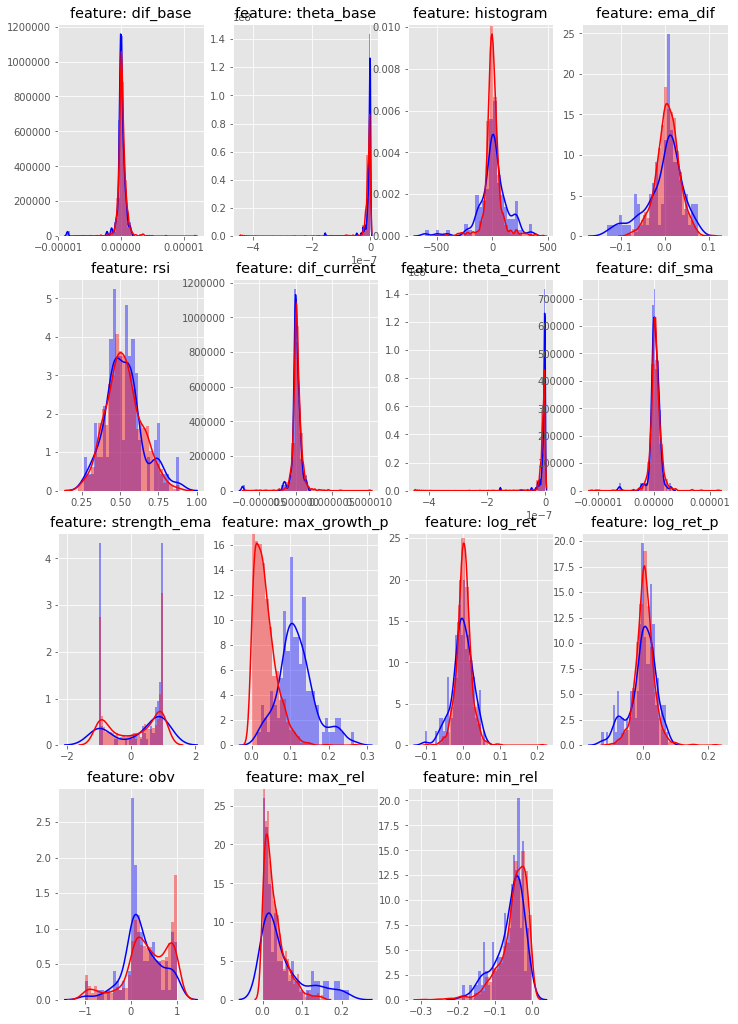

In [10]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(train.drop(['growth_sign'], axis=1).columns):
    ax = plt.subplot(gs[i])
    sns.distplot(train[cn][train.growth_sign == 1], bins=30, color='blue')
    sns.distplot(train[cn][train.growth_sign == 0], bins=30, color='red')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [11]:
# #EXAMPLE FOR SCALE NEW ENTRY
t_transform = scaler.transform(df.loc[0,scale_columns].values.reshape(1,-1))
print(t_transform)

[[ -5.41479362e-09  -5.76161575e-07  -5.36064750e-09  -6.35996719e-07
   -9.08928156e-07   1.00000000e+00   0.00000000e+00]]


In [12]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [13]:
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

# RANDOM FOREST
print('Random Forest')
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf':np.arange(1, 8),}
model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='precision')
model.fit(X_train_os, Y_train_os)
Y_predict = model.predict(X_test)

print(model.best_params_)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)

print('---------------------------------------------------')

print('AdaBoost')
# ADABOOST
param_grid = {'n_estimators': np.arange(1, 32)}
model = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='precision')
model.fit(X_train_os, Y_train_os)
Y_predict = model.predict(X_test)

print(model.best_params_)

cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)

Random Forest
{'max_depth': 15, 'min_samples_leaf': 1}
Precision: 0.5625
[[372  21]
 [ 12  27]]
---------------------------------------------------
AdaBoost
{'n_estimators': 26}
Precision: 0.5925925925925926
[[371  22]
 [  7  32]]


In [14]:
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

s_model = AdaBoostClassifier(random_state=42, n_estimators=30)
s_model.fit(X_train_os, Y_train_os)
Y_predict = s_model.predict(X_test)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
FP, TP, thresholds = roc_curve(y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

Precision: 0.5849056603773585
[[371  22]
 [  8  31]]
0.869446075553
